In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Load dataset
file_path = "C:/Users/dell/OneDrive/Desktop/STUDIES/UG3/Math Modeling/Engaging Dataset (2).xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")
df["Word"] = df["Word"].astype(str).str.upper()
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors='coerce')
df["Weekday"] = df["Date"].dt.weekday  # 0 = Monday, 6 = Sunday

# Define clusters
letter_clusters = {
    "BL", "BR", "CH", "CL", "CR", "DR", "FL", "FR", "GL", "GR", "PL", "PR", "SC", "SH", "SK", "SL", "SM", "SN",
    "SP", "ST", "SW", "TR", "TW", "WH", "WR", "BLT", "BRD", "CHR", "CLD", "CLT", "CRB", "CRD", "CRT", "DRB",
    "DRL", "FLT", "FRT", "GLT", "GRB", "GRT", "PLT", "PRD", "PRT", "SCR", "SHD", "SHR", "SKT", "SLD", "SLT",
    "SMD", "SMT", "SPD", "SPL", "SPR", "SPT", "STR", "SWD", "TRB", "TRD", "TRT", "TWD", "WRB", "WRT",
    "AI", "AU", "EA", "EI", "EO", "IA", "IE", "IO", "OA", "OE", "OI", "OU", "UA", "UE", "UI", "AIN", "AIR",
    "AIT", "EAU", "EAR", "EAT", "EER", "IER", "IOU", "OAR", "OAT", "OUR", "UAR"
}

def letter_complexity(word):
    if len(word) != 5:
        return None
    rare_letters = set("QXZJVWF")
    unique_letters = set(word)
    repeat_factor = (len(word) - len(unique_letters)) * 2
    rare_factor = sum(2.5 for letter in word if letter in rare_letters)
    vowel_penalty = 3 if word[0].upper() in "AEIOU" else 0
    cluster_bonus = -2 if any(cluster in word for cluster in letter_clusters) else 0
    return (2.5 * rare_factor) + (2 * repeat_factor) + (3 * vowel_penalty) - (2 * cluster_bonus)

def compute_parameters(word):
    word = word.upper()
    vowel_count = sum(1 for letter in word if letter in "AEIOU")
    consonant_count = 5 - vowel_count
    rare_letter_count = sum(1 for letter in word if letter in "QXZJVWF")
    cluster_present = any(cluster in word for cluster in letter_clusters)
    return vowel_count, consonant_count, rare_letter_count, cluster_present

df = df[df["Word"].apply(lambda x: isinstance(x, str) and len(x) == 5)]
df["Letter Complexity"] = df["Word"].apply(letter_complexity)
df = df.dropna(subset=["Letter Complexity"])
df[["Vowel Count", "Consonant Count", "Rare Letter Count", "Cluster Present"]] = df["Word"].apply(lambda x: pd.Series(compute_parameters(x)))

# KMeans clustering for difficulty
features = df[["Letter Complexity"]].copy()
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(features)
cluster_means = kmeans.cluster_centers_[:, 0]
sorted_indices = np.argsort(cluster_means)
cluster_labels = {sorted_indices[0]: "Easy", sorted_indices[1]: "Medium", sorted_indices[2]: "Hard"}
df["Difficulty"] = df["Cluster"].map(cluster_labels)
difficulty_mapping = {"Easy": 1, "Medium": 2, "Hard": 3}
df["Difficulty Value"] = df["Difficulty"].map(difficulty_mapping)

# Features for both models
X = df[["Difficulty Value", "Vowel Count", "Consonant Count", "Rare Letter Count", "Weekday"]]
y_avg = df["Avg Solve"]

# Use integer column names for tries
y_multi = df[[i for i in range(1, 7)]]

# Train model to predict average tries
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y_avg)
best_model = grid_search.best_estimator_

# Train model to predict try distribution
multi_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
multi_model.fit(X, y_multi)

# Prediction functions
def classify_new_word(word):
    word = word.upper()
    if len(word) != 5:
        return "Invalid word length."
    complexity = letter_complexity(word)
    if complexity is None:
        return "Invalid word format."
    cluster = kmeans.predict(pd.DataFrame([[complexity]], columns=["Letter Complexity"]))[0]
    return cluster_labels[cluster]

def predict_avg_tries(word, weekday):
    difficulty = classify_new_word(word)
    if difficulty in difficulty_mapping:
        difficulty_value = difficulty_mapping[difficulty]
        vowel_count, consonant_count, rare_letter_count, _ = compute_parameters(word)
        features = np.array([[difficulty_value, vowel_count, consonant_count, rare_letter_count, weekday]]).reshape(1, -1)
        
        avg = round(best_model.predict(features)[0], 2)
        distribution = multi_model.predict(features)[0]
        
        # Round distribution values for Try 1 to Try 6
        distribution_rounded = [round(val, 4) for val in distribution]
        
        return difficulty, avg, distribution_rounded
    return difficulty, None, None



# User input
user_word = input("\nEnter a 5-letter word: ").strip().upper()
user_weekday = int(input("Enter the weekday (0 = Monday, 6 = Sunday): "))
difficulty, predicted_tries, try_distribution = predict_avg_tries(user_word, user_weekday)

# Output
print(f"\nWord: {user_word}")
print(f"Difficulty: {difficulty}")
print(f"Predicted Avg Tries: {predicted_tries}")
print(f"Predicted Try Distribution (Try 1 to Try 6): {try_distribution}")



Word: SPATE
Difficulty: Easy
Predicted Avg Tries: 4.12
Predicted Try Distribution (Try 1 to Try 6): [0.3374, 6.0395, 25.8488, 34.5646, 21.6783, 8.5774]


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate the model for predicted average tries
def evaluate_avg_tries_model():
    y_avg_pred = best_model.predict(X)
    mse = mean_squared_error(y_avg, y_avg_pred)
    mae = mean_absolute_error(y_avg, y_avg_pred)
    r2 = r2_score(y_avg, y_avg_pred)
    rmse = np.sqrt(mse)
    
    print("\nEvaluation Metrics for Predicted Avg Tries:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

# Evaluate the overall performance for predicted try distribution
def evaluate_overall_try_distribution():
    y_multi_pred = multi_model.predict(X)

    # Compute overall metrics
    overall_mse = mean_squared_error(y_multi, y_multi_pred)
    overall_mae = mean_absolute_error(y_multi, y_multi_pred)
    overall_r2 = r2_score(y_multi, y_multi_pred)
    overall_rmse = np.sqrt(overall_mse)

    print("\nOverall Evaluation Metrics for Predicted Try Distribution:")
    print(f"Overall Mean Squared Error (MSE): {overall_mse:.4f}")
    print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse:.4f}")
    print(f"Overall Mean Absolute Error (MAE): {overall_mae:.4f}")
    print(f"Overall R-squared (R²): {overall_r2:.4f}")

# Run evaluations
evaluate_avg_tries_model()
evaluate_overall_try_distribution()



Evaluation Metrics for Predicted Avg Tries:
Mean Squared Error (MSE): 0.1499
Root Mean Squared Error (RMSE): 0.3871
Mean Absolute Error (MAE): 0.2867
R-squared (R²): 0.2374

Overall Evaluation Metrics for Predicted Try Distribution:
Overall Mean Squared Error (MSE): 58.0804
Overall Root Mean Squared Error (RMSE): 7.6210
Overall Mean Absolute Error (MAE): 3.6936
Overall R-squared (R²): 0.2533


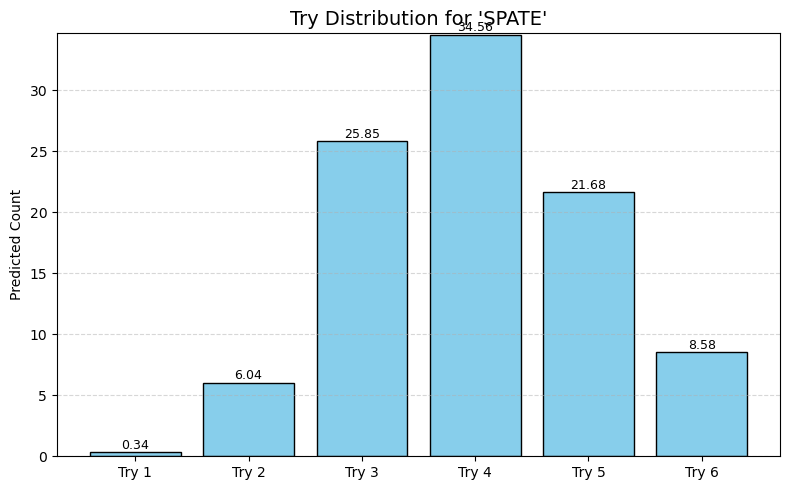

In [3]:
import matplotlib.pyplot as plt

def plot_distribution(distribution, word):
    tries = [f"Try {i}" for i in range(1, 7)]
    values = distribution

    plt.figure(figsize=(8, 5))
    bars = plt.bar(tries, values, color='skyblue', edgecolor='black')

    # Annotate bars with values
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f"{val:.2f}", ha='center', va='bottom', fontsize=9)

    plt.title(f"Try Distribution for '{word}'", fontsize=14)
    plt.ylabel("Predicted Count")
    plt.ylim(0, max(values) + 0.1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage
plot_distribution(try_distribution, user_word)
